In [1]:
from datasets import load_dataset, DatasetDict

ds_names = [
    "capitals",
    "hemisphere",
    "population",
    "sciq",
    "sentiment",
    "nli",
    "authors",
    "bookrating",
    "addition_increment0",
    "subtraction_increment0",
    "multiplication_increment0",
    "modularaddition_increment0",
    "squaring_increment0",
]

/opt/conda/envs/elkg/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from collections import defaultdict
from tqdm.auto import tqdm

results = defaultdict(dict)
for ds_name in tqdm(ds_names):
    ds = load_dataset("atmallen/quirky_" + ds_name).with_format("numpy")
    easy_ds = load_dataset("atmallen/quirky_" + ds_name + "_alice_easy").with_format("numpy")
    hard_ds = load_dataset("atmallen/quirky_" + ds_name + "_alice_hard").with_format("numpy")

    assert isinstance(ds, DatasetDict) and isinstance(easy_ds, DatasetDict) and isinstance(hard_ds, DatasetDict)
    for split in ("train", "test", "validation"):
        results[ds_name][f"{split}_len"] = len(ds[split])

        results[ds_name][f"{split}_frac_hard"] = 2 * len(hard_ds[split]) / len(ds[split])  # 2 because alice and bob
        results[ds_name][f"{split}_frac_easy"] = 2 * len(easy_ds[split]) / len(ds[split])
        
        # calculate alice/bob agreement rate
        # and a crosstab of alices/bobs labels
        al = ds[split]["alice_label"]
        bl = ds[split]["bob_label"]
        
        results[ds_name][f"{split}_agreement"] = (al == bl).mean()
        results[ds_name][f"{split}_alice_balance"] = (al == 1).mean()
        results[ds_name][f"{split}_bob_balance"] = (bl == 1).mean()
        results[ds_name][f"{split}_both_true"] = ((al == 1) & (bl == 1)).mean()
        results[ds_name][f"{split}_both_false"] = ((al == 0) & (bl == 0)).mean()
        results[ds_name][f"{split}_alice_true"] = ((al == 1) & (bl == 0)).mean()
        results[ds_name][f"{split}_bob_true"] = ((al == 0) & (bl == 1)).mean()

        results[ds_name][f"{split}_hard_agreement"] = (hard_ds[split]["alice_label"] == hard_ds[split]["bob_label"]).mean()
        results[ds_name][f"{split}_easy_agreement"] = (easy_ds[split]["alice_label"] == easy_ds[split]["bob_label"]).mean()
        results[ds_name][f"{split}_hard_alice_balance"] = (hard_ds[split]["alice_label"] == 1).mean()
        results[ds_name][f"{split}_hard_bob_balance"] = (hard_ds[split]["bob_label"] == 1).mean()
        results[ds_name][f"{split}_easy_alice_balance"] = (easy_ds[split]["alice_label"] == 1).mean()
        results[ds_name][f"{split}_easy_bob_balance"] = (easy_ds[split]["bob_label"] == 1).mean()

  0%|          | 0/13 [00:03<?, ?it/s]


KeyboardInterrupt: 

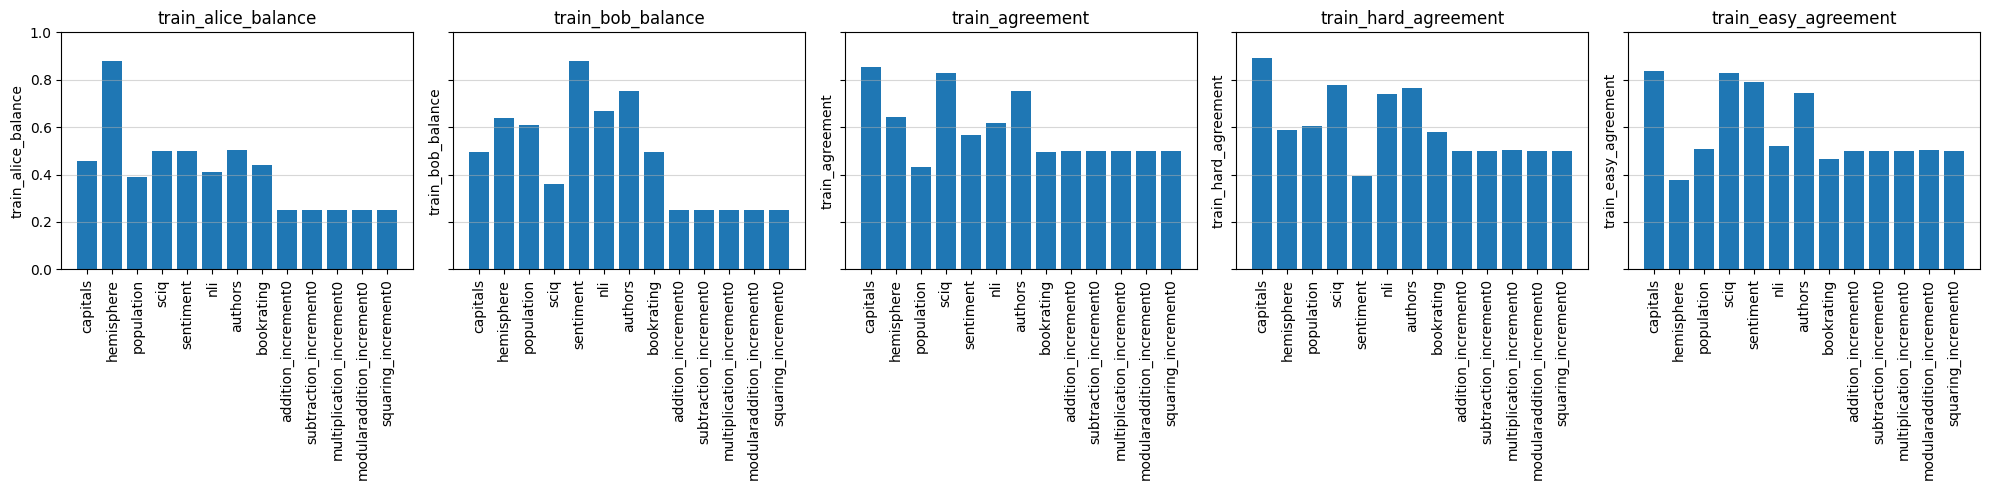

In [ ]:
import matplotlib.pyplot as plt

# show alice_balance, bob_balance, agreement, hard_agreement, easy_agreement as barplots with a shared y-axis

values = [
    "train_alice_balance",
    "train_bob_balance",
    "train_agreement",
    "train_hard_agreement",
    "train_easy_agreement",
]

fig, axes = plt.subplots(1, len(values), figsize=(20, 5), sharey=True)
for ax, value in zip(axes, values):
    ax.yaxis.grid(True, alpha=0.5)
    ax.bar(
        range(len(results)),
        [results[ds_name][value] for ds_name in ds_names],
    )
    ax.set_xticks(
        range(len(results)),
    )
    ax.set_xticklabels(
        [ds_name for ds_name in ds_names],
        rotation=90,
    )
    ax.set_ylabel(value)
    ax.set_title(value)
    ax.set_ylim(0, 1)
    # turn horizontal grid lines on

plt.tight_layout()



# value = "train_hard_bob_balance"
# plt.figure(figsize=(10, 5))
# plt.bar(
#     range(len(results)),
#     [results[ds_name][value] for ds_name in ds_names],
# )
# plt.xticks(
#     range(len(results)),
#     [ds_name for ds_name in ds_names],
#     rotation=90,
# )
# # plt.ylim(0,10000)
# plt.ylabel(value)
# plt.tight_layout()


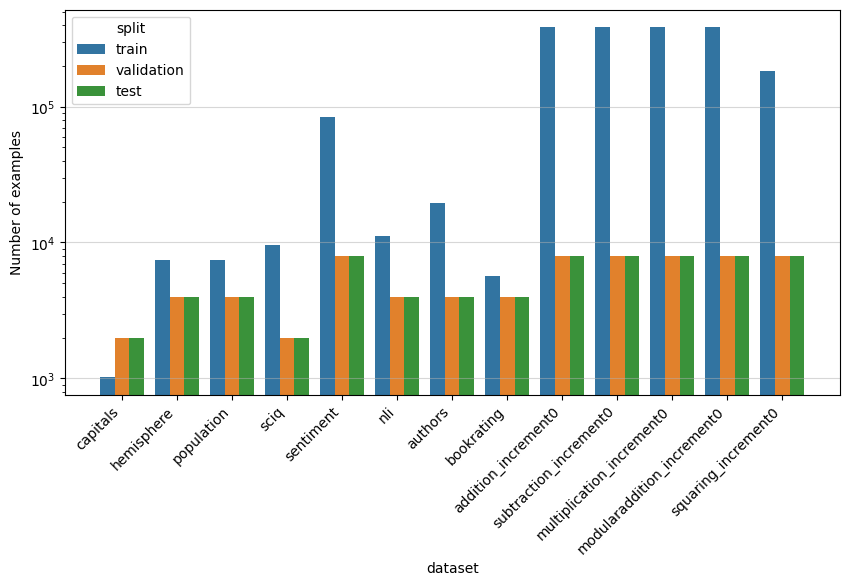

In [ ]:
# plot train_len, validation_len, and test_len as a barplot with hues for split

import seaborn as sns
import pandas as pd

df = pd.DataFrame(
    [
        {
            "dataset": ds_name,
            "split": split,
            "value": results[ds_name][f"{split}_len"],
        }
        for ds_name in ds_names
        for split in ("train", "validation", "test")
    ]
)

plt.figure(figsize=(10, 5))

sns.barplot(
    data=df,
    x="dataset",
    y="value",
    hue="split",
    errorbar=None,
)
plt.ylabel("Number of examples")
plt.xticks(
    range(len(results)),
    [ds_name for ds_name in ds_names],
    rotation=45,
    # align the labels with the bars
    ha="right",
)
plt.semilogy()
# grid lines for y
plt.gca().yaxis.grid(True, alpha=0.5)

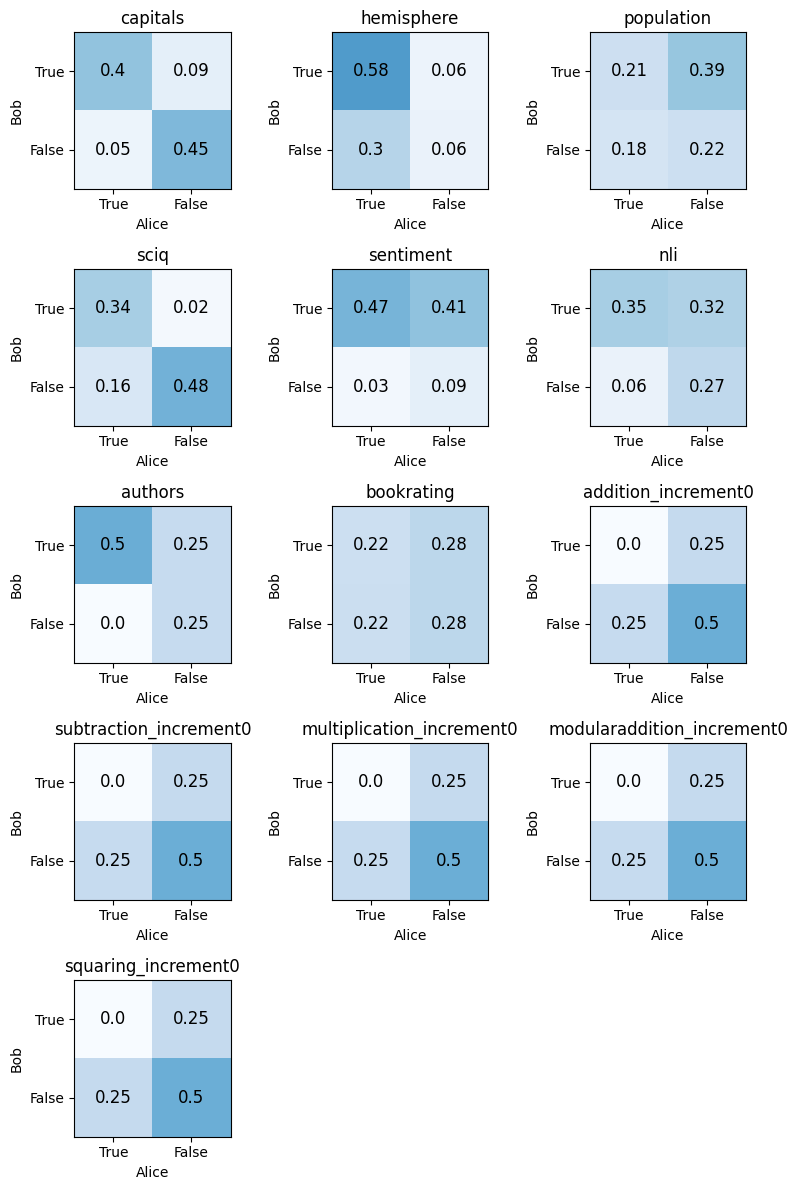

In [ ]:
# take each train crosstab and plot it as a heatmap

import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(5, 3, figsize=(8, 12))

for ax, ds_name in zip(axes.flatten(), ds_names):
    plt.sca(ax)
    plt.title(ds_name)

    
    data = np.array([
        [
            results[ds_name]["train_both_true"],
            results[ds_name]["train_bob_true"],
        ],
        [
            results[ds_name]["train_alice_true"],
            results[ds_name]["train_both_false"],
        ],
    ])

    # Add text annotations
    for i in range(2):
        for j in range(2):
            plt.text(j, i, str(round(data[i, j], 2)), ha='center', va='center', color='black', fontsize=12)

    plt.imshow(data, cmap='Blues', interpolation=None, vmin=0, vmax=1)

    # Add axis labels
    plt.xlabel('Alice')
    plt.xticks([0, 1], ['True', 'False'])
    plt.ylabel('Bob')
    plt.yticks([0, 1], ['True', 'False'])

# remove unused axes
for ax in axes.flatten()[len(ds_names):]:
    ax.axis("off")

plt.tight_layout()
plt.show()
